In [6]:
import os
import re
import spacy
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [7]:
try:
    df = pd.read_csv('../data/raw/german_courts.csv')
    print(f"Daten geladen: {len(df)} Einträge")
except Exception as e:
    print(f"Fehler beim Laden der Daten: {e}")

Daten geladen: 6592 Einträge


In [8]:
# Auf Duplikate prüfen
print(f"Anzahl der doppelten Zeilen: {df.duplicated().sum()}")
print(f"Anzahl der doppelten IDs: {df['id'].duplicated().sum()}")

Anzahl der doppelten Zeilen: 0
Anzahl der doppelten IDs: 0


In [9]:
# Prüfung auf Urteile ohne Pressemitteilungen und umgekehrt
print("\nPrüfung auf fehlende Inhalte:")
# Leere oder fehlende Zusammenfassungen finden
missing_summaries = df[df['summary'].isna() | (
    df['summary'].str.strip() == '')]
print(f"Anzahl der Einträge ohne Pressemitteilung: {len(missing_summaries)}")
if len(missing_summaries) > 0:
    print("Beispiele für fehlende Pressemitteilungen:")
    print(missing_summaries[['id', 'date', 'judgement']].head(3))

# Leere oder fehlende Urteile finden
missing_judgements = df[df['judgement'].isna() | (
    df['judgement'].str.strip() == '')]
print(f"Anzahl der Einträge ohne Urteil: {len(missing_judgements)}")
if len(missing_judgements) > 0:
    print("Beispiele für fehlende Urteile:")
    print(missing_judgements[['id', 'date', 'summary']].head(3))


Prüfung auf fehlende Inhalte:
Anzahl der Einträge ohne Pressemitteilung: 0
Anzahl der Einträge ohne Urteil: 0


In [10]:
def is_announcement_rule_based(row):
    """Erkennt Ankündigungen und nicht urteilsbezogene Mitteilungen anhand von Keywords und Mustern"""
    if pd.isna(row['summary']):
        return False, None
    
    summary = str(row['summary']).lower()
    
    # 1. Keywords, die auf Ankündigungen hindeuten
    future_indicators = [
        'ankündigung', 'terminankündigung', 'terminhinweis', 'hinweis auf termin',
        'wird verhandelt', 'wird verhandeln', 'wird.*stattfinden', 'findet statt',
        'einladung', 'pressetermin', 'pressekonferenz', 'veranstaltung',
        'wochenvorschau', 'jahrespressekonferenz', 'pressegespräch', 'rundgang',
        'beginnt am', 'laden ein', 'lädt ein', 'sitzung vom', 
    ]
    
    # 2. Regex-Muster für Datumsangaben in der Zukunft (relativ zum Erstelldatum)
    date_patterns = [
        r'am\s+(\d{1,2})\.(\d{1,2})\.(\d{4})',  # "am 15.05.2023"
        r'am\s+(\d{1,2})\.(\d{1,2})\.',         # "am 15.05."
        r'vom\s+(\d{1,2})\.(\d{1,2})\.(\d{4})?', # "vom 15.05.2023" oder "vom 15.05."
        r'terminiert auf den (\d{1,2})\.(\d{1,2})\.(\d{4})?',  # "terminiert auf den 15.05.2023"
        r'findet\s+am\s+(\d{1,2})\.(\d{1,2})\.(\d{4})?\s+statt', # "findet am 15.05.2023 statt"
        r'verhandelt\s+am\s+(\d{1,2})\.(\d{1,2})\.(\d{4})?', # "verhandelt am 15.05.2023"
    ]
    
    # 3. Überschriften/Anfänge, die auf Ankündigungen hindeuten
    headline_indicators = [
        'presseinformation', 'information für die presse',
        'medieninformation', 'zur information', 
        'terminvorschau', 'jahresbericht', 'geschäftsbericht', 'tätigkeitsbericht',
        'stellenausschreibung', 'personelle veränderungen', 'neuer präsident', 
        'akkreditierung','sehr geehrt'
    ]

    # Ich experimentiere noch irgendwas wie mit 'nicht zur entscheidung angenommen', da sind viele false positives dabei
    
    # 4. Prüfen auf Keywords am Anfang des Textes (größeres Gewicht)
    summary_start = summary[:500]
    
    # Speichere die gefundenen Kriterien
    matching_criteria = []
    
    # Headline Prüfung mit genauen Matches
    for indicator in headline_indicators:
        if indicator in summary_start:
            matching_criteria.append(f"Headline: {indicator}")
    
    # Keyword Prüfung
    for indicator in future_indicators:
        if re.search(r'\b' + re.escape(indicator) + r'\b', summary, re.IGNORECASE):
            matching_criteria.append(f"Keyword: {indicator}")
    
    # Prüfen, ob die Pressemitteilung ein Datum enthält
    # Wir extrahieren hier das Datum und vergleichen es mit dem Veröffentlichungsdatum
    future_date_found = False
    current_date = None
    
    # Versuchen, das Veröffentlichungsdatum zu parsen
    try:
        if 'date' in row and pd.notna(row['date']):
            current_date = pd.to_datetime(row['date'], errors='coerce')
    except:
        current_date = None
    
    # Wenn kein Veröffentlichungsdatum vorhanden ist, können wir keine zeitliche Prüfung machen
    if current_date is not None:
        # Aktuelle Jahreszahl für unvollständige Datumsmuster
        current_year = current_date.year
        
        for pattern in date_patterns:
            for match in re.finditer(pattern, summary, re.IGNORECASE):
                try:
                    groups = match.groups()
                    if len(groups) >= 2:
                        day = int(groups[0])
                        month = int(groups[1])
                        # Jahr ist nicht immer angegeben, daher nehmen wir das aktuelle Jahr, wenn es fehlt
                        year = int(groups[2]) if len(groups) > 2 and groups[2] is not None else current_year
                        
                        # Datumsvalidierung (einfache Prüfung)
                        if 1 <= day <= 31 and 1 <= month <= 12 and 1900 <= year <= 2100:
                            # Datum aus dem Text konstruieren
                            event_date = pd.to_datetime(f"{year}-{month:02d}-{day:02d}", errors='coerce')
                            
                            # Prüfen, ob das Datum gültig ist und in der Zukunft liegt
                            if pd.notna(event_date) and event_date > current_date:
                                # Prüfen, ob das Datum mindestens einen Tag später ist
                                days_diff = (event_date - current_date).days
                                if days_diff >= 1:
                                    future_date_found = True
                                    matching_criteria.append(f"Datum: {match.group(0)} (+{days_diff} Tage)")
                except Exception as e:
                    # Bei Fehlern in der Datumsverarbeitung ignorieren wir diesen Match
                    continue
    
    # Unspezifische zukünftige Zeitangaben (als fallback)
    future_time_indicators = [
        r'in der kommenden woche',
        r'in der nächsten woche',
        r'demnächst'
    ]
    
    for pattern in future_time_indicators:
        if re.search(pattern, summary, re.IGNORECASE):
            matching_criteria.append(f"Zeitraum: {pattern}")
            # Diese gelten immer als zukünftig
            future_date_found = True
    
    # Kombinierte Entscheidung mit unterschiedlicher Gewichtung
    headline_match = any("Headline:" in criterion for criterion in matching_criteria)
    keyword_match = any("Keyword:" in criterion for criterion in matching_criteria)
    
    # Eine Ankündigung muss entweder einen Headline-Indikator haben,
    # oder eine Kombination aus Keyword und Datums-Hinweis
    if headline_match or (keyword_match and future_date_found):
        return True, " | ".join(matching_criteria)
    
    return False, None  # Default: keine Ankündigung

# Anwenden der modifizierten regelbasierten Methode auf den Datensatz
results = df.apply(is_announcement_rule_based, axis=1)
df['is_announcement_rule'] = [result[0] for result in results]
df['matching_criteria'] = [result[1] for result in results]

# Auswertung der regelbasierten Methode
announcement_count = df['is_announcement_rule'].sum()
print(f"Regelbasierte Erkennung: {announcement_count} von {len(df)} Einträgen ({announcement_count/len(df)*100:.2f}%) sind vermutlich Ankündigungen.")

# Beispiele für erkannte Ankündigungen anzeigen mit den Matching-Kriterien
announcement_examples = df[df['is_announcement_rule']]

Regelbasierte Erkennung: 160 von 6592 Einträgen (2.43%) sind vermutlich Ankündigungen.


In [11]:
# Anzeigen einiger Beispiele mit den zugehörigen Kriterien
print("\nBeispiele für erkannte Ankündigungen mit Match-Kriterien:")
sample_announcements = announcement_examples.sample(min(5, len(announcement_examples)))
for idx, row in sample_announcements.iterrows():
    print(f"\nID: {row['id']}")
    print(f"Kriterien: {row['matching_criteria']}")
    print(f"Zusammenfassung (Auszug): {row['summary'][:200]}...")


Beispiele für erkannte Ankündigungen mit Match-Kriterien:

ID: bgh_029-2022
Kriterien: Keyword: veranstaltung | Datum: vom 2.3.2022 (+27 Tage)
Zusammenfassung (Auszug): Mietzahlungspflicht bei coronabedingter Absage einer Hochzeitsfeier


Ausgabejahr 2022
Erscheinungsdatum 02.03.2022


        Nr. 029/2022
      

Urteil vom 2. März 2022 – XII ZR 36/21 
Der u.a. für ...

ID: bgh_178-2014
Kriterien: Headline: sehr geehrt | Keyword: terminhinweis | Datum: vom 20.1.2015 (+314 Tage)
Zusammenfassung (Auszug): Terminhinweis in Sachen VI ZR 137/14 für den 20. Januar 2015


Ausgabejahr 2014
Erscheinungsdatum 03.12.2014


        Nr. 178/2014
      
Sehr geehrte Damen und Herren, 
wir möchten auf folgenden Ter...

ID: 15-2016
Kriterien: Headline: akkreditierung
Zusammenfassung (Auszug): Wesentliche Entscheidungen zur Akkreditierung von Studiengängen muss der Gesetzgeber selbst treffen
Pressemitteilung Nr. 15/2016 vom 18. März 2016
Beschluss vom 17. Februar 20161 BvL 8/10
Die Regelung...

ID: b

In [12]:
# Analyse der häufigsten Kriterien
if not announcement_examples.empty:
    all_criteria = []
    for criteria_str in announcement_examples['matching_criteria'].dropna():
        all_criteria.extend(criteria_str.split(" | "))
    
    criteria_counts = Counter(all_criteria)
    print("\nHäufigste Match-Kriterien:")
    for criterion, count in criteria_counts.most_common(20):
        print(f"{criterion}: {count} Mal")


Häufigste Match-Kriterien:
Keyword: terminhinweis: 126 Mal
Headline: sehr geehrt: 122 Mal
Keyword: veranstaltung: 10 Mal
Keyword: ankündigung: 7 Mal
Headline: akkreditierung: 6 Mal
Headline: zur information: 4 Mal
Datum: vom 28.6.2016 (+439 Tage): 2 Mal
Datum: vom 17.9.2004 (+18 Tage): 2 Mal
Keyword: beginnt am: 2 Mal
Datum: vom 21.12.2011 (+7 Tage): 2 Mal
Datum: vom 09.11.2006 (+59 Tage): 2 Mal
Headline: stellenausschreibung: 1 Mal
Keyword: einladung: 1 Mal
Datum: vom 26.1.2011 (+9 Tage): 1 Mal
Datum: vom 14.6.2006 (+146 Tage): 1 Mal
Datum: vom 22.3.2011 (+62 Tage): 1 Mal
Datum: vom 30.4.2014 (+100 Tage): 1 Mal
Datum: vom 15.2.2012 (+26 Tage): 1 Mal
Datum: vom 30.7.2015 (+917 Tage): 1 Mal
Datum: vom 7.5.2015 (+833 Tage): 1 Mal


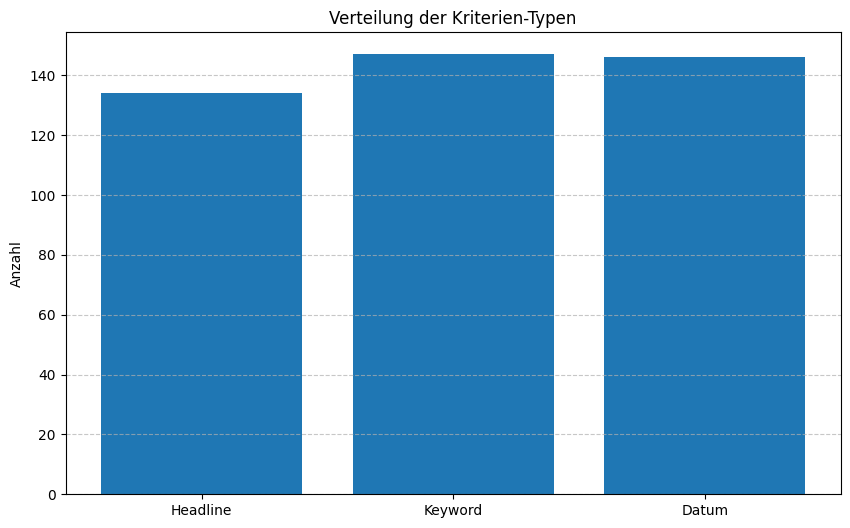

In [13]:
# Visualisierung der Kriterien-Verteilung
if not announcement_examples.empty:
    criteria_types = ['Headline', 'Keyword', 'Datum']
    type_counts = {t: sum(1 for c in all_criteria if c.startswith(f"{t}:")) for t in criteria_types}
    
    plt.figure(figsize=(10, 6))
    plt.bar(type_counts.keys(), type_counts.values())
    plt.title('Verteilung der Kriterien-Typen')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [14]:
interim_dir = '../data/interim/'
# Verzeichnis erstellen, falls es nicht existiert
os.makedirs(interim_dir, exist_ok=True)

# 1. Alle herausgefilterten Ankündigungen speichern (die entfernt werden)
removed_df = df[df['is_announcement_rule'] == True]
removed_path = os.path.join(interim_dir, 'removed.csv')
removed_df.to_csv(removed_path, index=False)
print(f"\nHerausgefilterte Ankündigungen gespeichert: {len(removed_df)} Einträge in {removed_path}")

# 2. Bereinigte Daten speichern (ohne Ankündigungen)
cleaned_df = df[df['is_announcement_rule'] == False]
cleaned_path = os.path.join(interim_dir, 'cleaned.csv')
cleaned_df.to_csv(cleaned_path, index=False)
print(f"Bereinigte Daten gespeichert: {len(cleaned_df)} Einträge in {cleaned_path}")

# Statistik anzeigen
print(f"\nZusammenfassung:")
print(f"- Ursprüngliche Datensatzgröße: {len(df)} Einträge")
print(f"- Entfernte Ankündigungen: {len(removed_df)} Einträge ({len(removed_df)/len(df)*100:.2f}%)")
print(f"- Verbleibende Daten: {len(cleaned_df)} Einträge ({len(cleaned_df)/len(df)*100:.2f}%)")


Herausgefilterte Ankündigungen gespeichert: 160 Einträge in ../data/interim/removed.csv
Bereinigte Daten gespeichert: 6432 Einträge in ../data/interim/cleaned.csv

Zusammenfassung:
- Ursprüngliche Datensatzgröße: 6592 Einträge
- Entfernte Ankündigungen: 160 Einträge (2.43%)
- Verbleibende Daten: 6432 Einträge (97.57%)
